# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data?resource=download . Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [4]:
# Your code here
import pandas as pd
fraud = pd.read_csv("Fraud.csv")
fraud =fraud.sample(100000)
fraud.head(3)

### What is the distribution of the outcome? 

In [12]:
# Your response here
fraud['isFraud'].value_counts()

0    99865
1      135
Name: isFraud, dtype: int64

### Clean the dataset. Pre-process it to make it suitable for ML training. Feel free to explore, drop, encode, transform, etc. Whatever you feel will improve the model score.

In [11]:
# Your code here
fraud.reset_index(drop=True, inplace=True)
print(fraud.dtypes)
print(fraud.isnull().sum())
print(fraud.describe())
print(fraud['isFraud'].value_counts())



step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  100000.000000  1.000000e+05   1.000000e+05    1.000000e+05   
mean      243.182210  1.789950e+05   8.255569e+05    8.462663e+05   
std       142.344454  5.508978e+05   2.871842e+06    2.908200e+06   
min         1.000000  4.200000e-01   0.000000e+00    0.000000e+00   
25%       155.000000  1.330154e+04   0.000000e+00    0.000000e+00   
50%       240.000000  7.436776e+04   1.433550e+04    

Description of variables:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction."

)

In [45]:
fraud_fraud = fraud[fraud['isFraud']==1]
fraud_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,135.000000,1.350000e+02,1.350000e+02,1.350000e+02,1.350000e+02,1.350000e+02,135.0,135.0
mean,380.874074,1.599545e+06,1.677318e+06,9.456287e+04,8.724718e+05,1.658152e+06,1.0,0.0
std,207.254060,2.601072e+06,3.019144e+06,8.489773e+05,2.277507e+06,3.054189e+06,0.0,0.0
min,8.000000,1.190000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0
25%,202.000000,1.405990e+05,1.306879e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0
50%,401.000000,4.202702e+05,4.078336e+05,0.000000e+00,0.000000e+00,4.392831e+04,1.0,0.0
75%,561.500000,1.427027e+06,1.368475e+06,0.000000e+00,2.712020e+05,1.935445e+06,1.0,0.0
max,739.000000,1.000000e+07,1.959384e+07,9.593839e+06,1.212949e+07,1.401885e+07,1.0,0.0


In [46]:
fraud_no_fraud = fraud[fraud['isFraud']==0]
fraud_no_fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,99865.000000,9.986500e+04,9.986500e+04,9.986500e+04,9.986500e+04,9.986500e+04,99865.0,99865.0
mean,242.996075,1.770747e+05,8.244055e+05,8.472825e+05,1.094777e+06,1.219359e+06,0.0,0.0
std,142.147927,5.404524e+05,2.871483e+06,2.909868e+06,3.336522e+06,3.576434e+06,0.0,0.0
min,1.000000,4.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,155.000000,1.327511e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
50%,239.000000,7.418265e+04,1.421220e+04,0.000000e+00,1.303032e+05,2.133033e+05,0.0,0.0
75%,335.000000,2.065875e+05,1.057770e+05,1.406503e+05,9.405993e+05,1.101704e+06,0.0,0.0
max,718.000000,4.363841e+07,3.893942e+07,3.894623e+07,2.580347e+08,2.582821e+08,0.0,0.0


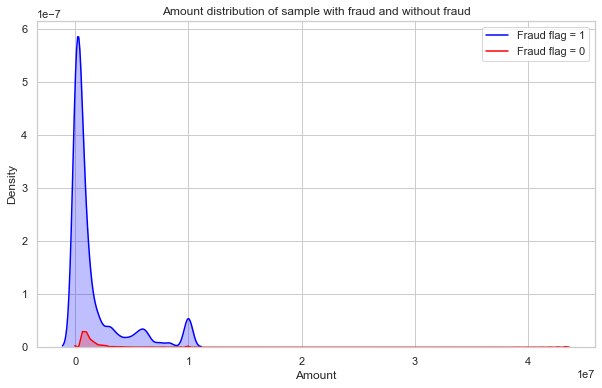

Fraud transaction are normally with less amount, more homogenious. Normal transaction is not so homogenious.
mean of the amount of fraud transactions: 1599545.2272592585
mean of the amount of fraud transactions: 1599545.2272592585 Percentile 80: 2065423.158
mean of the amount of no fraud transactions: 177074.6767604264 Percentile 80: 243752.56000000026


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['amount'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['amount'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Amount distribution of sample with fraud and without fraud')
plt.xlabel('Amount')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
percentile_80 = np.percentile(fraud_fraud['amount'], 80)
print('Fraud transaction are normally with less amount, more homogenious. Normal transaction is not so homogenious.')
print('mean of the amount of fraud transactions:',fraud_fraud['amount'].mean())


# Imprimir el percentil 80%
print('mean of the amount of fraud transactions:',fraud_fraud['amount'].mean(),'Percentile 80:',np.percentile(fraud_fraud['amount'], 80))
print('mean of the amount of no fraud transactions:',fraud_no_fraud['amount'].mean(),'Percentile 80:',np.percentile(fraud_no_fraud['amount'], 80))

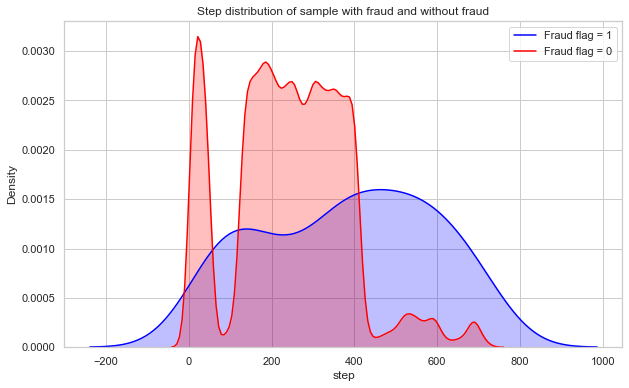

not so intuitive


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['step'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['step'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Step distribution of sample with fraud and without fraud')
plt.xlabel('step')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('not so intuitive')

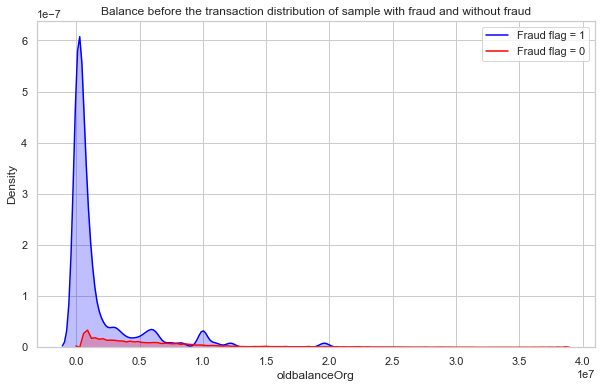

mean of the balance before transactions  of fraud transactions: 1677318.0904444437 Percentile 90: 5626110.996000003
mean of the balance before transactions  of no fraud transactions: 824405.5175022242 Percentile 90: 1729417.3900000015
Very intuitive, less balance in the origin account before fraud


In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['oldbalanceOrg'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['oldbalanceOrg'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Balance before the transaction distribution of sample with fraud and without fraud')
plt.xlabel('oldbalanceOrg')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('mean of the balance before transactions  of fraud transactions:',fraud_fraud['oldbalanceOrg'].mean(),'Percentile 90:',np.percentile(fraud_fraud['oldbalanceOrg'], 90))
print('mean of the balance before transactions  of no fraud transactions:',fraud_no_fraud['oldbalanceOrg'].mean(),'Percentile 90:',np.percentile(fraud_no_fraud['oldbalanceOrg'], 90)
     )
print('Very intuitive, less balance in the origin account before fraud')

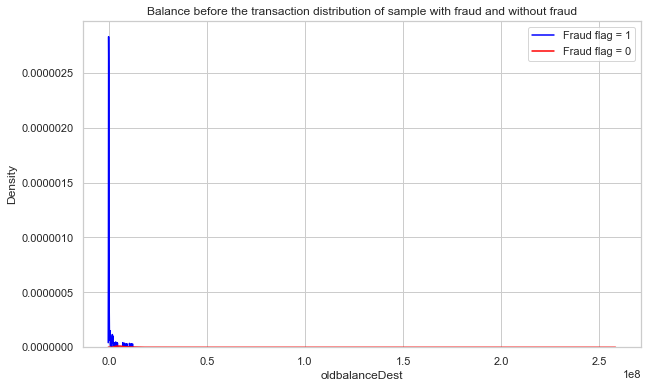

mean of the balance in dest. before transactions  of fraud transactions: 872471.7959259262 Percentile 90: 2352043.834000001
mean of the balance before transactions in dest.  of no fraud transactions: 1094777.0854387255 Percentile 90: 2923470.768
Very intuitive, less balance in dest. for fraud transactions


In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['oldbalanceDest'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['oldbalanceDest'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Balance before the transaction distribution of sample with fraud and without fraud')
plt.xlabel('oldbalanceDest')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('mean of the balance in dest. before transactions  of fraud transactions:',fraud_fraud['oldbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_fraud['oldbalanceDest'], 90))
print('mean of the balance before transactions in dest.  of no fraud transactions:',fraud_no_fraud['oldbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_no_fraud['oldbalanceDest'], 90)
     )
print('Very intuitive, less balance in dest. for fraud transactions')

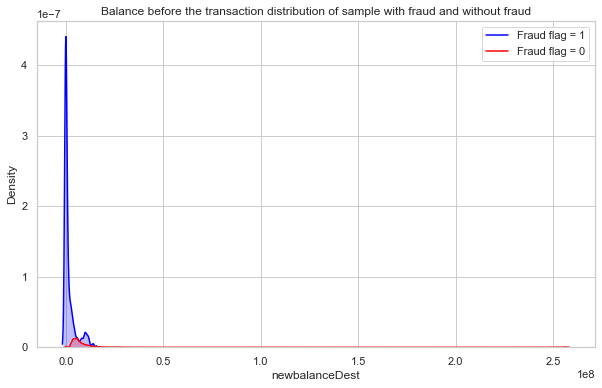

mean of the balance in dest. after transactions  of fraud transactions: 1658151.9147407406 Percentile 90: 5729113.688000005
mean of the balance after transactions in dest.  of no fraud transactions: 1219359.292511093 Percentile 90: 3202636.682
Very intuitive, less balance in dest. for fraud transactions


In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))

sns.kdeplot(fraud_fraud['newbalanceDest'], shade=True, label='Fraud flag = 1', color='blue')
sns.kdeplot(fraud_no_fraud['newbalanceDest'], shade=True, label='Fraud flag = 0', color='red')

# Añadir título y etiquetas de los ejes
plt.title('Balance before the transaction distribution of sample with fraud and without fraud')
plt.xlabel('newbalanceDest')
plt.ylabel('Density')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
print('mean of the balance in dest. after transactions  of fraud transactions:',fraud_fraud['newbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_fraud['newbalanceDest'], 90))
print('mean of the balance after transactions in dest.  of no fraud transactions:',fraud_no_fraud['newbalanceDest'].mean(),'Percentile 90:',np.percentile(fraud_no_fraud['newbalanceDest'], 90)
     )
print('Very intuitive, less balance in dest. for fraud transactions')

In [58]:
print(fraud_fraud['type'].unique())
print(fraud_no_fraud['type'].unique())

['TRANSFER' 'CASH_OUT']
['CASH_OUT' 'PAYMENT' 'CASH_IN' 'TRANSFER' 'DEBIT']


### Run a logisitc regression classifier and evaluate its accuracy.

In [67]:
# Your code here

print('Candidate variables: step, amount and choosing one of these, as there are correlated:newbalanceDest,oldbalanceDest')
fraud.columns
X_A = fraud[[ 'amount','oldbalanceOrg','oldbalanceDest']]
#.drop({'isFraud','type','oldbalanceOrg', 'newbalanceOrig','nameDest','newbalanceDest'}, axis = 1)
y_A = fraud['isFraud']
from sklearn.model_selection import train_test_split
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A)

X_B = fraud[[ 'amount','newbalanceOrig','newbalanceDest']]
#.drop({'isFraud','type','oldbalanceOrg', 'newbalanceOrig','nameDest','newbalanceDest'}, axis = 1)
y_B = fraud['isFraud']

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B)


Candidate variables: step, amount and choosing one of these, as there are correlated:newbalanceDest,oldbalanceDest


### Now pick a model of your choice and evaluate its accuracy.

In [68]:
# Your code here
from sklearn.linear_model import LogisticRegression

Regression_Model_A = LogisticRegression(max_iter=1000)
Regression_Model_A.fit(X_train_A, y_train_A)
print('Model A:',Regression_Model_A.score(X_test_A, y_test_A))

Regression_Model_B = LogisticRegression(max_iter=1000)
Regression_Model_B.fit(X_train_B, y_train_B)
print('Model B:',Regression_Model_B.score(X_test_B, y_test_B))


Model A: 0.99856
Model B: 0.99868


### Which model worked better and how do you know?

In [70]:
# Your response here
print('Too similar models')
fraud.to_csv('fraud_reduced_sample.csv')

Too similar models


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.